# Follow-Me Project
Congratulations on reaching the final project of the Robotics Nanodegree! 

Previously, you worked on the Semantic Segmentation lab where you built a deep learning network that locates a particular human target within an image. For this project, you will utilize what you implemented and learned from that lab and extend it to train a deep learning model that will allow a simulated quadcopter to follow around the person that it detects! 

Most of the code below is similar to the lab with some minor modifications. You can start with your existing solution, and modify and improve upon it to train the best possible model for this task.

You can click on any of the following to quickly jump to that part of this notebook:
1. [Data Collection](#data)
2. [FCN Layers](#fcn)
3. [Build the Model](#build)
4. [Training](#training)
5. [Prediction](#prediction)
6. [Evaluation](#evaluation)

## Data Collection<a id='data'></a>
We have provided you with a starting dataset for this project. Download instructions can be found in the README for this project's repo.
Alternatively, you can collect additional data of your own to improve your model. Check out the "Collecting Data" section in the Project Lesson in the Classroom for more details!

In [1]:
import os
import glob
import sys
import tensorflow as tf

from scipy import misc
import numpy as np

from tensorflow.contrib.keras.python import keras
from tensorflow.contrib.keras.python.keras import layers, models

from tensorflow import image

from utils import scoring_utils
from utils.separable_conv2d import SeparableConv2DKeras, BilinearUpSampling2D
from utils import data_iterator
from utils import plotting_tools 
from utils import model_tools

## FCN Layers <a id='fcn'></a>
In the Classroom, we discussed the different layers that constitute a fully convolutional network (FCN). The following code will introduce you to the functions that you need to build your semantic segmentation model.

### Separable Convolutions
The Encoder for your FCN will essentially require separable convolution layers, due to their advantages as explained in the classroom. The 1x1 convolution layer in the FCN, however, is a regular convolution. Implementations for both are provided below for your use. Each includes batch normalization with the ReLU activation function applied to the layers. 

In [2]:
def separable_conv2d_batchnorm(input_layer, filters, strides=1):
    output_layer = SeparableConv2DKeras(filters=filters,kernel_size=3, strides=strides,
                             padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

def conv2d_batchnorm(input_layer, filters, kernel_size=3, strides=1):
    output_layer = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, 
                      padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

### Bilinear Upsampling
The following helper function implements the bilinear upsampling layer. Upsampling by a factor of 2 is generally recommended, but you can try out different factors as well. Upsampling is used in the decoder block of the FCN.

In [3]:
def bilinear_upsample(input_layer):
    output_layer = BilinearUpSampling2D((2,2))(input_layer)
    return output_layer

## Build the Model <a id='build'></a>
In the following cells, you will build an FCN to train a model to detect and locate the hero target within an image. The steps are:
- Create an `encoder_block`
- Create a `decoder_block`
- Build the FCN consisting of encoder block(s), a 1x1 convolution, and decoder block(s).  This step requires experimentation with different numbers of layers and filter sizes to build your model.

### Encoder Block
Create an encoder block that includes a separable convolution layer using the `separable_conv2d_batchnorm()` function. The `filters` parameter defines the size or depth of the output layer. For example, 32 or 64. 

In [4]:
def encoder_block(input_layer, filters, strides):
    
    # TODO Create a separable convolution layer using the separable_conv2d_batchnorm() function.
    # yhnam
    return separable_conv2d_batchnorm(input_layer, filters, strides)

### Decoder Block
The decoder block is comprised of three parts:
- A bilinear upsampling layer using the upsample_bilinear() function. The current recommended factor for upsampling is set to 2.
- A layer concatenation step. This step is similar to skip connections. You will concatenate the upsampled small_ip_layer and the large_ip_layer.
- Some (one or two) additional separable convolution layers to extract some more spatial information from prior layers.

In [5]:
def decoder_block(small_ip_layer, large_ip_layer, filters):
    
    # TODO Upsample the small input layer using the bilinear_upsample() function.
    upsampled = bilinear_upsample(small_ip_layer)
    # TODO Concatenate the upsampled and large input layers using layers.concatenate
    # Lesson 6-11
    concatenated = layers.concatenate([upsampled, large_ip_layer])
    # TODO Add some number of separable convolution layers
    # Lesson 6-9 
    preoutput_layer = separable_conv2d_batchnorm(concatenated, filters)
    output_layer = separable_conv2d_batchnorm(preoutput_layer, filters)
    return output_layer

### Model

Now that you have the encoder and decoder blocks ready, go ahead and build your FCN architecture! 

There are three steps:
- Add encoder blocks to build the encoder layers. This is similar to how you added regular convolutional layers in your CNN lab.
- Add a 1x1 Convolution layer using the conv2d_batchnorm() function. Remember that 1x1 Convolutions require a kernel and stride of 1.
- Add decoder blocks for the decoder layers.

In [6]:
def fcn_model(inputs, num_classes):
    filters = 32
    strides = 2
    # TODO Add Encoder Blocks. 
    # Remember that with each encoder layer, the depth of your model (the number of filters) increases.
    L1 = encoder_block(inputs, filters, strides)
    L2 = encoder_block(L1, filters*2, strides)
    L3 = encoder_block(L2, filters*4, strides)
    
    # TODO Add 1x1 Convolution layer using conv2d_batchnorm().
    # Will be same size
    L2D = conv2d_batchnorm(L3, filters*4, kernel_size=1, strides=1) 
    
    # TODO: Add the same number of Decoder Blocks as the number of Encoder Blocks
    decoder_L1 = decoder_block(L2D, L2, filters*4)
    decoder_L2 = decoder_block(decoder_L1, L1, filters*2)
    decoder_L3 = decoder_block(decoder_L2, inputs, filters)
    
    # The function returns the output layer of your model. "x" is the final layer obtained from the last decoder_block()
    return layers.Conv2D(num_classes, 1, activation='softmax', padding='same')(decoder_L3)

## Training <a id='training'></a>
The following cells will use the FCN you created and define an ouput layer based on the size of the processed image and the number of classes recognized. You will define the hyperparameters to compile and train your model.

Please Note: For this project, the helper code in `data_iterator.py` will resize the copter images to 160x160x3 to speed up training.

In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

image_hw = 160
image_shape = (image_hw, image_hw, 3)
inputs = layers.Input(image_shape)
num_classes = 3

# Call fcn_model()
output_layer = fcn_model(inputs, num_classes)

### Hyperparameters
Define and tune your hyperparameters.
- **batch_size**: number of training samples/images that get propagated through the network in a single pass.
- **num_epochs**: number of times the entire training dataset gets propagated through the network.
- **steps_per_epoch**: number of batches of training images that go through the network in 1 epoch. We have provided you with a default value. One recommended value to try would be based on the total number of images in training dataset divided by the batch_size.
- **validation_steps**: number of batches of validation images that go through the network in 1 epoch. This is similar to steps_per_epoch, except validation_steps is for the validation dataset. We have provided you with a default value for this as well.
- **workers**: maximum number of processes to spin up. This can affect your training speed and is dependent on your hardware. We have provided a recommended value to work with. 

In [8]:
learning_rate = 0.001
batch_size = 42
num_epochs = 100
steps_per_epoch = 70
validation_steps = 30
workers = 4

Epoch 1/100
69/70 [============================>.] - ETA: 1s - loss: 0.9553

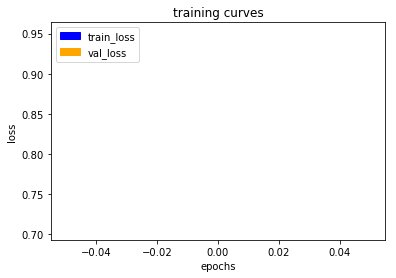

70/70 [==============================] - 84s - loss: 0.9517 - val_loss: 0.7057
Epoch 2/100
69/70 [============================>.] - ETA: 0s - loss: 0.4577

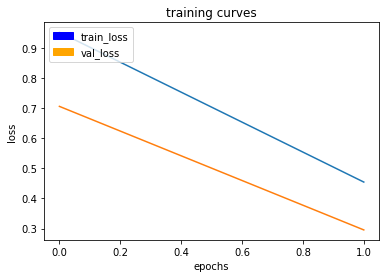

70/70 [==============================] - 55s - loss: 0.4548 - val_loss: 0.2957
Epoch 3/100
69/70 [============================>.] - ETA: 0s - loss: 0.1702

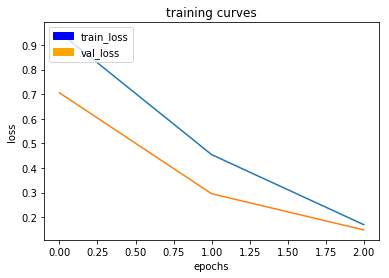

70/70 [==============================] - 55s - loss: 0.1694 - val_loss: 0.1486
Epoch 4/100
69/70 [============================>.] - ETA: 0s - loss: 0.0894

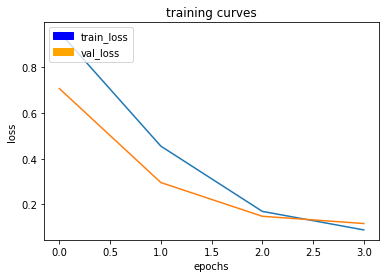

70/70 [==============================] - 55s - loss: 0.0890 - val_loss: 0.1170
Epoch 5/100
69/70 [============================>.] - ETA: 0s - loss: 0.0618

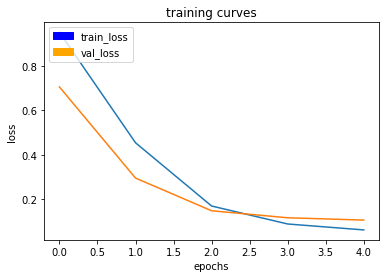

70/70 [==============================] - 55s - loss: 0.0624 - val_loss: 0.1066
Epoch 6/100
69/70 [============================>.] - ETA: 0s - loss: 0.0509

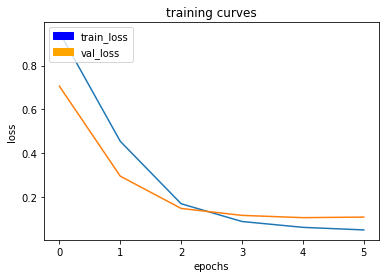

70/70 [==============================] - 55s - loss: 0.0508 - val_loss: 0.1091
Epoch 7/100
69/70 [============================>.] - ETA: 0s - loss: 0.0457

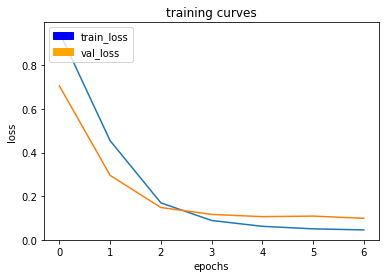

70/70 [==============================] - 55s - loss: 0.0458 - val_loss: 0.0991
Epoch 8/100
69/70 [============================>.] - ETA: 0s - loss: 0.0399

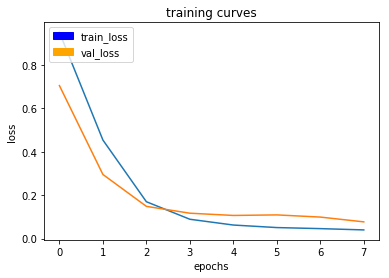

70/70 [==============================] - 55s - loss: 0.0399 - val_loss: 0.0770
Epoch 9/100
69/70 [============================>.] - ETA: 0s - loss: 0.0370

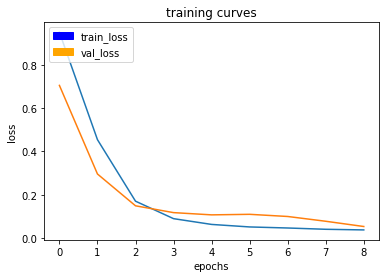

70/70 [==============================] - 55s - loss: 0.0369 - val_loss: 0.0527
Epoch 10/100
69/70 [============================>.] - ETA: 0s - loss: 0.0343

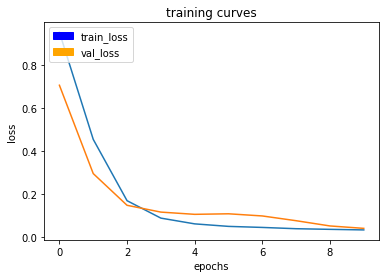

70/70 [==============================] - 55s - loss: 0.0343 - val_loss: 0.0415
Epoch 11/100
69/70 [============================>.] - ETA: 0s - loss: 0.0324

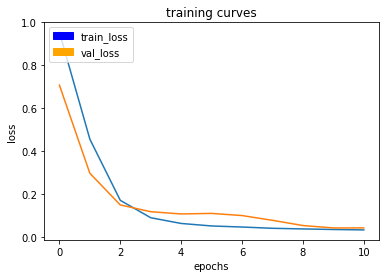

70/70 [==============================] - 55s - loss: 0.0324 - val_loss: 0.0416
Epoch 12/100
69/70 [============================>.] - ETA: 0s - loss: 0.0285

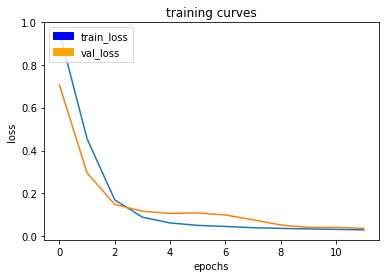

70/70 [==============================] - 55s - loss: 0.0297 - val_loss: 0.0367
Epoch 13/100
69/70 [============================>.] - ETA: 0s - loss: 0.0302

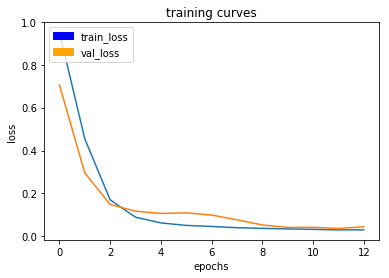

70/70 [==============================] - 55s - loss: 0.0304 - val_loss: 0.0440
Epoch 14/100
69/70 [============================>.] - ETA: 0s - loss: 0.0281

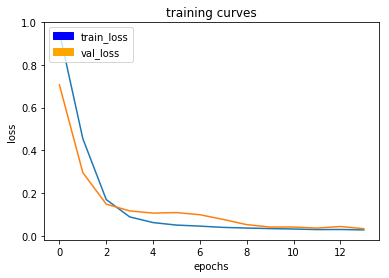

70/70 [==============================] - 55s - loss: 0.0281 - val_loss: 0.0338
Epoch 15/100
69/70 [============================>.] - ETA: 0s - loss: 0.0269

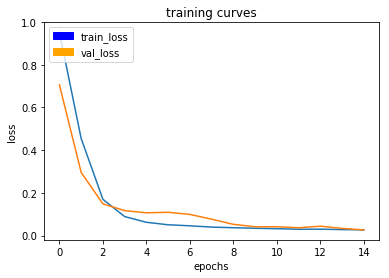

70/70 [==============================] - 55s - loss: 0.0269 - val_loss: 0.0266
Epoch 16/100
69/70 [============================>.] - ETA: 0s - loss: 0.0262

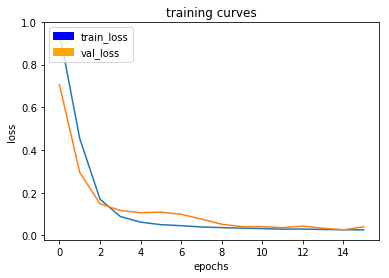

70/70 [==============================] - 55s - loss: 0.0262 - val_loss: 0.0408
Epoch 17/100
69/70 [============================>.] - ETA: 0s - loss: 0.0255

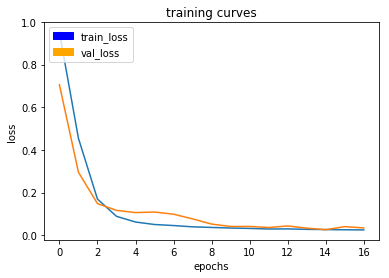

70/70 [==============================] - 55s - loss: 0.0254 - val_loss: 0.0347
Epoch 18/100
69/70 [============================>.] - ETA: 0s - loss: 0.0252

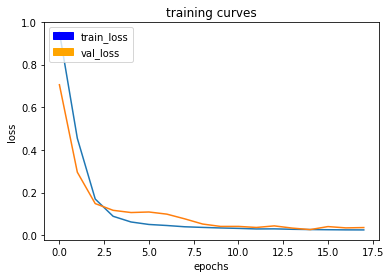

70/70 [==============================] - 55s - loss: 0.0252 - val_loss: 0.0362
Epoch 19/100
69/70 [============================>.] - ETA: 0s - loss: 0.0256

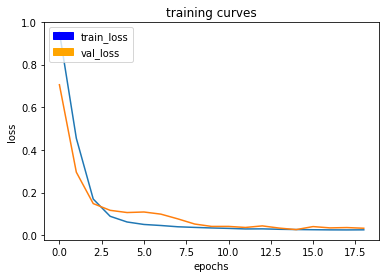

70/70 [==============================] - 55s - loss: 0.0256 - val_loss: 0.0330
Epoch 20/100
69/70 [============================>.] - ETA: 0s - loss: 0.0227

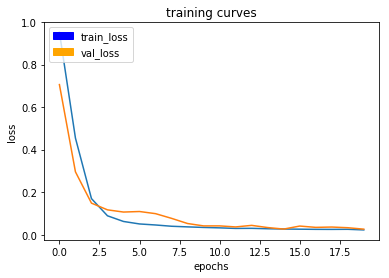

70/70 [==============================] - 55s - loss: 0.0227 - val_loss: 0.0262
Epoch 21/100
69/70 [============================>.] - ETA: 0s - loss: 0.0243

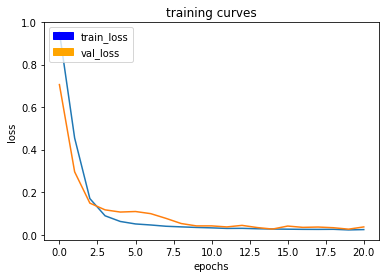

70/70 [==============================] - 56s - loss: 0.0242 - val_loss: 0.0367
Epoch 22/100
69/70 [============================>.] - ETA: 0s - loss: 0.0220

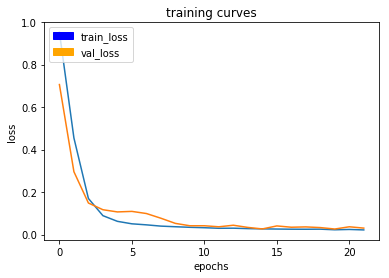

70/70 [==============================] - 55s - loss: 0.0220 - val_loss: 0.0305
Epoch 23/100
69/70 [============================>.] - ETA: 0s - loss: 0.0219

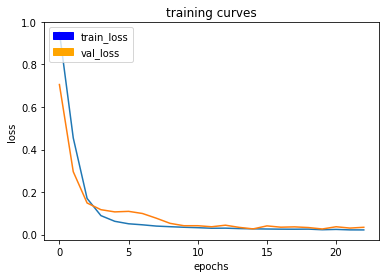

70/70 [==============================] - 55s - loss: 0.0218 - val_loss: 0.0342
Epoch 24/100
69/70 [============================>.] - ETA: 0s - loss: 0.0223

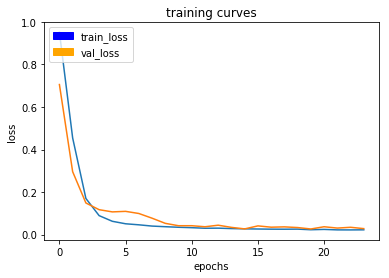

70/70 [==============================] - 55s - loss: 0.0223 - val_loss: 0.0279
Epoch 25/100
69/70 [============================>.] - ETA: 0s - loss: 0.0202

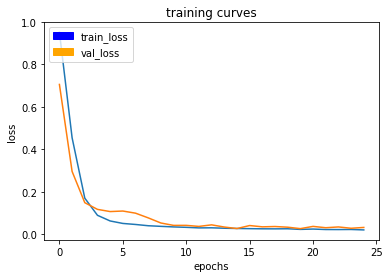

70/70 [==============================] - 55s - loss: 0.0202 - val_loss: 0.0318
Epoch 26/100
69/70 [============================>.] - ETA: 0s - loss: 0.0222

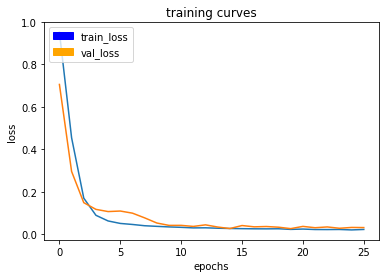

70/70 [==============================] - 55s - loss: 0.0223 - val_loss: 0.0312
Epoch 27/100
69/70 [============================>.] - ETA: 0s - loss: 0.0208

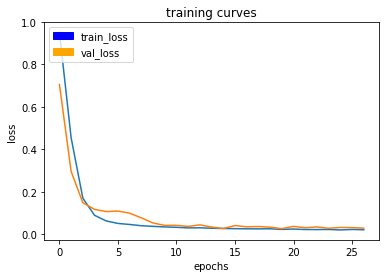

70/70 [==============================] - 55s - loss: 0.0208 - val_loss: 0.0285
Epoch 28/100
69/70 [============================>.] - ETA: 0s - loss: 0.0203

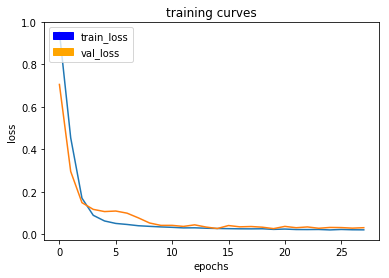

70/70 [==============================] - 56s - loss: 0.0205 - val_loss: 0.0306
Epoch 29/100
69/70 [============================>.] - ETA: 0s - loss: 0.0188

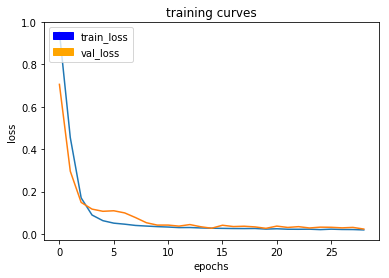

70/70 [==============================] - 55s - loss: 0.0187 - val_loss: 0.0229
Epoch 30/100
69/70 [============================>.] - ETA: 0s - loss: 0.0227

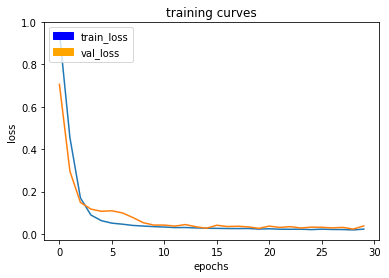

70/70 [==============================] - 55s - loss: 0.0227 - val_loss: 0.0377
Epoch 31/100
69/70 [============================>.] - ETA: 0s - loss: 0.0227

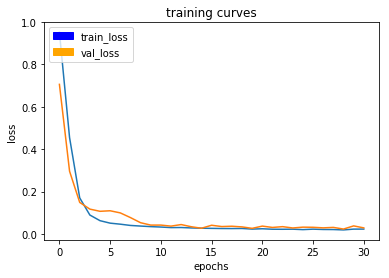

70/70 [==============================] - 55s - loss: 0.0226 - val_loss: 0.0284
Epoch 32/100
69/70 [============================>.] - ETA: 0s - loss: 0.0199

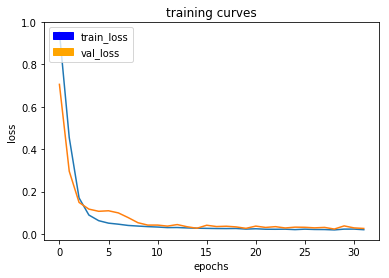

70/70 [==============================] - 54s - loss: 0.0198 - val_loss: 0.0256
Epoch 33/100
69/70 [============================>.] - ETA: 0s - loss: 0.0199

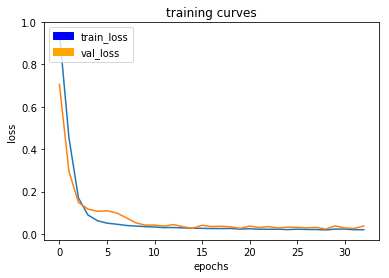

70/70 [==============================] - 55s - loss: 0.0198 - val_loss: 0.0371
Epoch 34/100
69/70 [============================>.] - ETA: 0s - loss: 0.0202

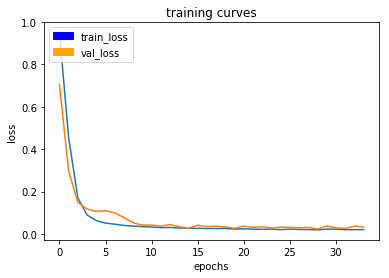

70/70 [==============================] - 54s - loss: 0.0202 - val_loss: 0.0326
Epoch 35/100
69/70 [============================>.] - ETA: 0s - loss: 0.0188

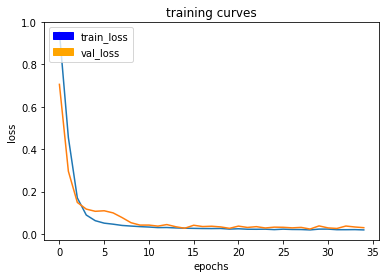

70/70 [==============================] - 55s - loss: 0.0188 - val_loss: 0.0293
Epoch 36/100
69/70 [============================>.] - ETA: 0s - loss: 0.0181

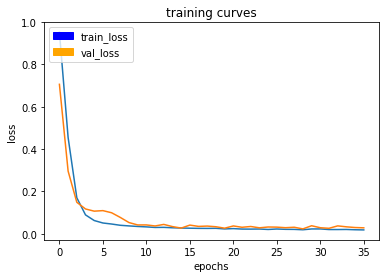

70/70 [==============================] - 55s - loss: 0.0180 - val_loss: 0.0279
Epoch 37/100
69/70 [============================>.] - ETA: 0s - loss: 0.0171

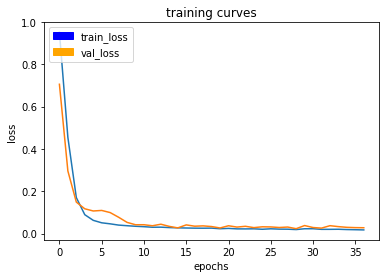

70/70 [==============================] - 55s - loss: 0.0172 - val_loss: 0.0273
Epoch 38/100
69/70 [============================>.] - ETA: 0s - loss: 0.0173

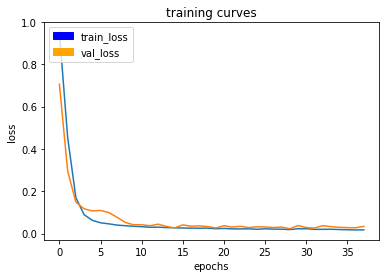

70/70 [==============================] - 55s - loss: 0.0173 - val_loss: 0.0336
Epoch 39/100
69/70 [============================>.] - ETA: 0s - loss: 0.0195

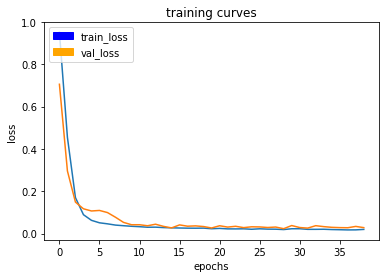

70/70 [==============================] - 55s - loss: 0.0194 - val_loss: 0.0279
Epoch 40/100
69/70 [============================>.] - ETA: 0s - loss: 0.0170

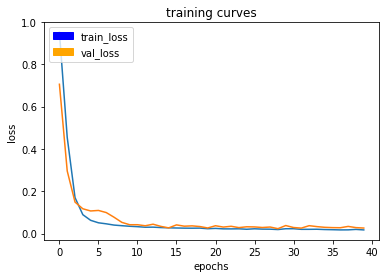

70/70 [==============================] - 55s - loss: 0.0170 - val_loss: 0.0259
Epoch 41/100
69/70 [============================>.] - ETA: 0s - loss: 0.0174

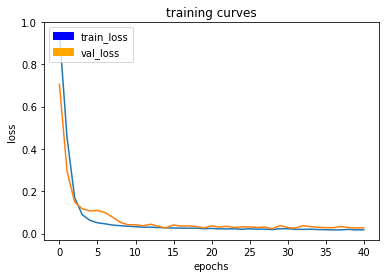

70/70 [==============================] - 55s - loss: 0.0174 - val_loss: 0.0274
Epoch 42/100
69/70 [============================>.] - ETA: 0s - loss: 0.0163

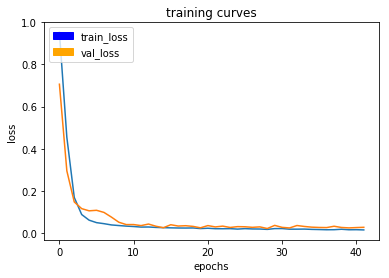

70/70 [==============================] - 55s - loss: 0.0163 - val_loss: 0.0286
Epoch 43/100
69/70 [============================>.] - ETA: 0s - loss: 0.0182

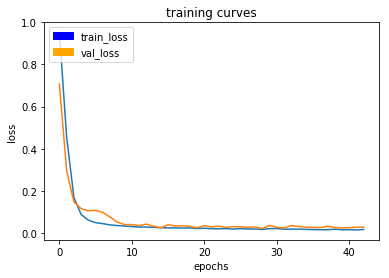

70/70 [==============================] - 55s - loss: 0.0183 - val_loss: 0.0292
Epoch 44/100
69/70 [============================>.] - ETA: 0s - loss: 0.0166

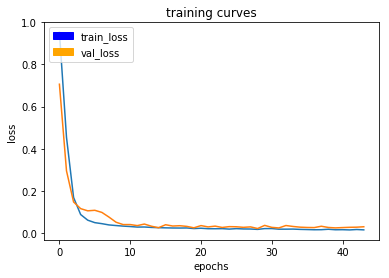

70/70 [==============================] - 55s - loss: 0.0165 - val_loss: 0.0312
Epoch 45/100
69/70 [============================>.] - ETA: 0s - loss: 0.0161

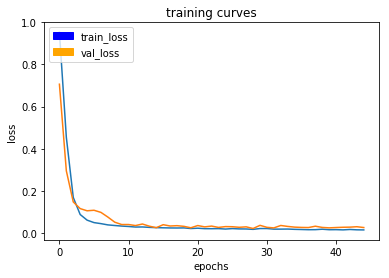

70/70 [==============================] - 55s - loss: 0.0161 - val_loss: 0.0274
Epoch 46/100
69/70 [============================>.] - ETA: 0s - loss: 0.0147

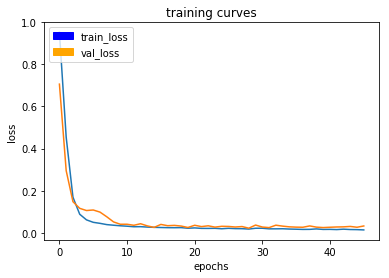

70/70 [==============================] - 55s - loss: 0.0147 - val_loss: 0.0334
Epoch 47/100
69/70 [============================>.] - ETA: 0s - loss: 0.0164

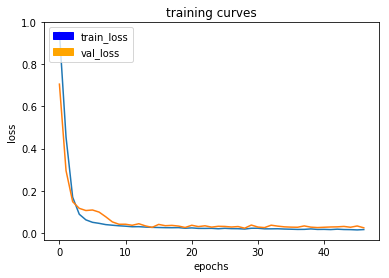

70/70 [==============================] - 55s - loss: 0.0164 - val_loss: 0.0247
Epoch 48/100
69/70 [============================>.] - ETA: 0s - loss: 0.0154

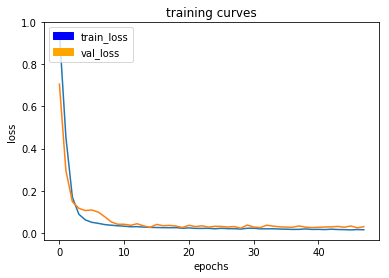

70/70 [==============================] - 55s - loss: 0.0155 - val_loss: 0.0301
Epoch 49/100
69/70 [============================>.] - ETA: 0s - loss: 0.0169

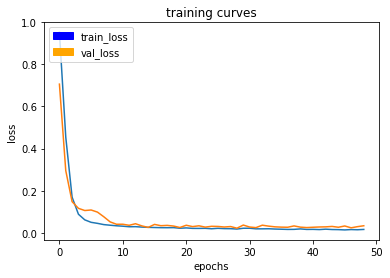

70/70 [==============================] - 55s - loss: 0.0170 - val_loss: 0.0344
Epoch 50/100
69/70 [============================>.] - ETA: 0s - loss: 0.0162

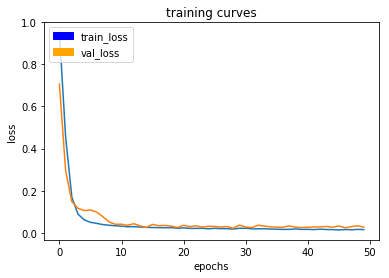

70/70 [==============================] - 55s - loss: 0.0162 - val_loss: 0.0279
Epoch 51/100
69/70 [============================>.] - ETA: 0s - loss: 0.0166

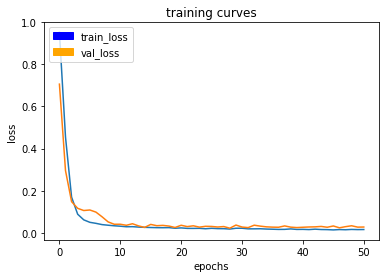

70/70 [==============================] - 55s - loss: 0.0166 - val_loss: 0.0284
Epoch 52/100
69/70 [============================>.] - ETA: 0s - loss: 0.0155

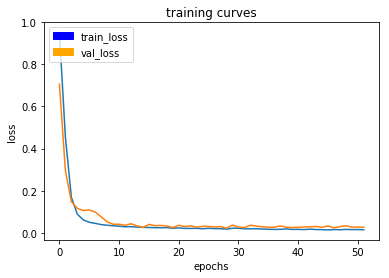

70/70 [==============================] - 55s - loss: 0.0155 - val_loss: 0.0275
Epoch 53/100
69/70 [============================>.] - ETA: 0s - loss: 0.0151

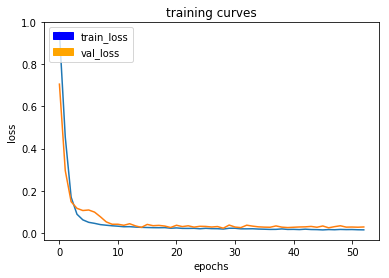

70/70 [==============================] - 55s - loss: 0.0151 - val_loss: 0.0287
Epoch 54/100
69/70 [============================>.] - ETA: 0s - loss: 0.0155

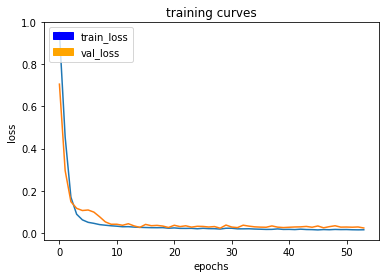

70/70 [==============================] - 55s - loss: 0.0154 - val_loss: 0.0239
Epoch 55/100
69/70 [============================>.] - ETA: 0s - loss: 0.0151

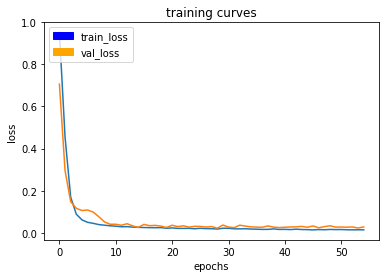

70/70 [==============================] - 55s - loss: 0.0151 - val_loss: 0.0289
Epoch 56/100
69/70 [============================>.] - ETA: 0s - loss: 0.0135

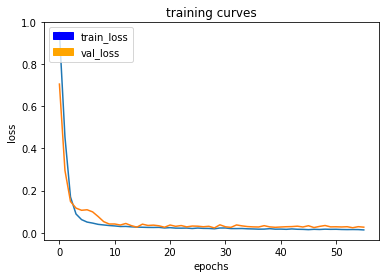

70/70 [==============================] - 55s - loss: 0.0135 - val_loss: 0.0265
Epoch 57/100
69/70 [============================>.] - ETA: 0s - loss: 0.0158

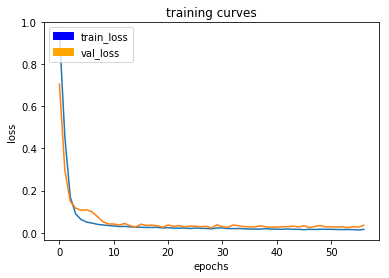

70/70 [==============================] - 55s - loss: 0.0158 - val_loss: 0.0358
Epoch 58/100
69/70 [============================>.] - ETA: 0s - loss: 0.0152

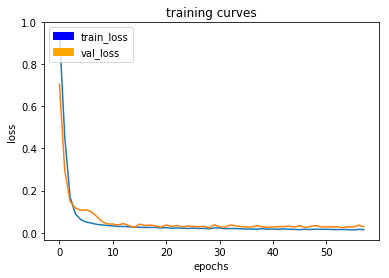

70/70 [==============================] - 55s - loss: 0.0152 - val_loss: 0.0290
Epoch 59/100
69/70 [============================>.] - ETA: 0s - loss: 0.0135

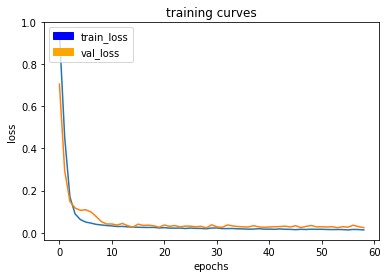

70/70 [==============================] - 55s - loss: 0.0135 - val_loss: 0.0244
Epoch 60/100
69/70 [============================>.] - ETA: 0s - loss: 0.0147

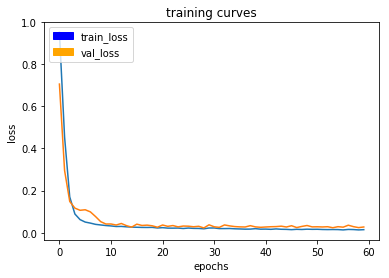

70/70 [==============================] - 55s - loss: 0.0147 - val_loss: 0.0274
Epoch 61/100
69/70 [============================>.] - ETA: 0s - loss: 0.0134

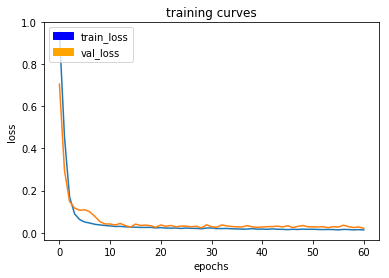

70/70 [==============================] - 55s - loss: 0.0134 - val_loss: 0.0206
Epoch 62/100
69/70 [============================>.] - ETA: 0s - loss: 0.0135

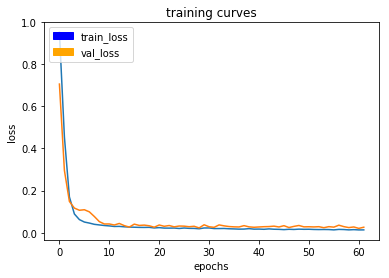

70/70 [==============================] - 55s - loss: 0.0135 - val_loss: 0.0262
Epoch 63/100
69/70 [============================>.] - ETA: 0s - loss: 0.0131

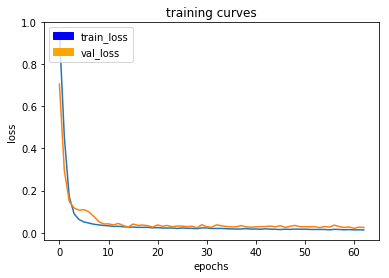

70/70 [==============================] - 55s - loss: 0.0131 - val_loss: 0.0244
Epoch 64/100
69/70 [============================>.] - ETA: 0s - loss: 0.0141

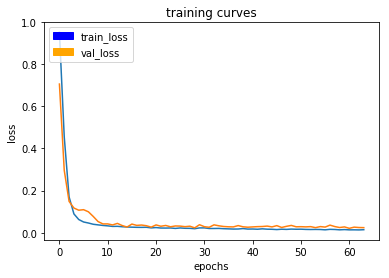

70/70 [==============================] - 55s - loss: 0.0141 - val_loss: 0.0238
Epoch 65/100
69/70 [============================>.] - ETA: 0s - loss: 0.0138

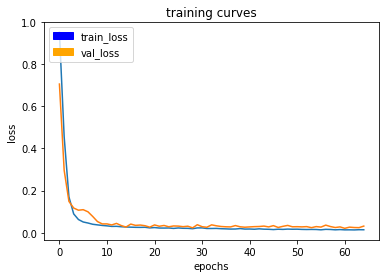

70/70 [==============================] - 55s - loss: 0.0138 - val_loss: 0.0311
Epoch 66/100
69/70 [============================>.] - ETA: 0s - loss: 0.0133

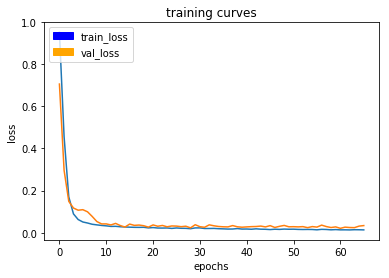

70/70 [==============================] - 55s - loss: 0.0133 - val_loss: 0.0337
Epoch 67/100
69/70 [============================>.] - ETA: 0s - loss: 0.0132

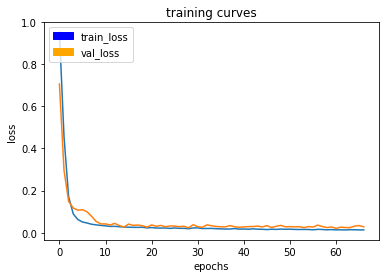

70/70 [==============================] - 55s - loss: 0.0132 - val_loss: 0.0278
Epoch 68/100
69/70 [============================>.] - ETA: 0s - loss: 0.0152

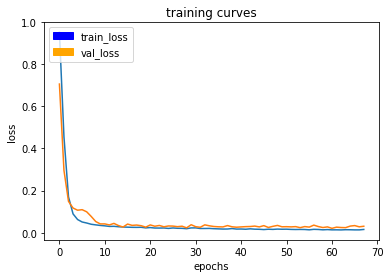

70/70 [==============================] - 55s - loss: 0.0152 - val_loss: 0.0305
Epoch 69/100
69/70 [============================>.] - ETA: 0s - loss: 0.0136

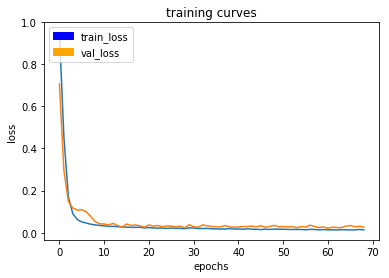

70/70 [==============================] - 55s - loss: 0.0136 - val_loss: 0.0266
Epoch 70/100
69/70 [============================>.] - ETA: 0s - loss: 0.0145

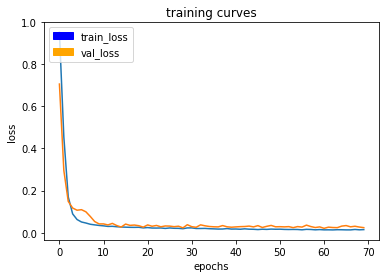

70/70 [==============================] - 55s - loss: 0.0145 - val_loss: 0.0238
Epoch 71/100
69/70 [============================>.] - ETA: 0s - loss: 0.0144

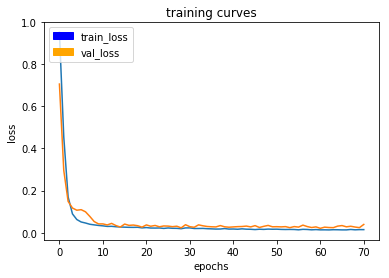

70/70 [==============================] - 55s - loss: 0.0144 - val_loss: 0.0390
Epoch 72/100
69/70 [============================>.] - ETA: 0s - loss: 0.0154

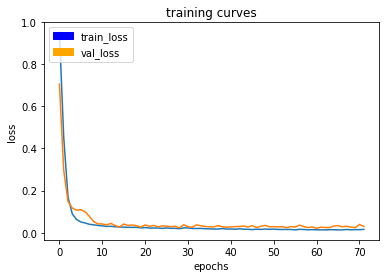

70/70 [==============================] - 55s - loss: 0.0154 - val_loss: 0.0294
Epoch 73/100
69/70 [============================>.] - ETA: 0s - loss: 0.0137

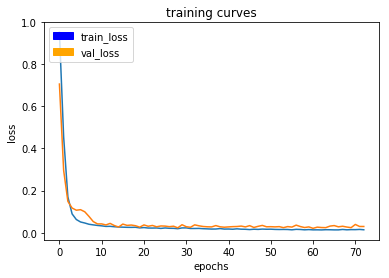

70/70 [==============================] - 55s - loss: 0.0137 - val_loss: 0.0293
Epoch 74/100
69/70 [============================>.] - ETA: 0s - loss: 0.0136

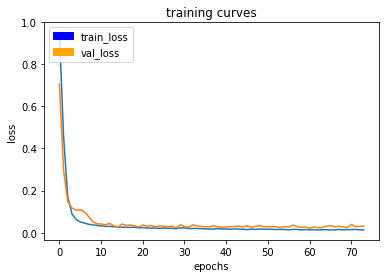

70/70 [==============================] - 55s - loss: 0.0136 - val_loss: 0.0312
Epoch 75/100
69/70 [============================>.] - ETA: 0s - loss: 0.0144

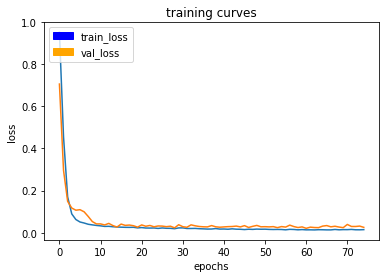

70/70 [==============================] - 55s - loss: 0.0144 - val_loss: 0.0252
Epoch 76/100
69/70 [============================>.] - ETA: 0s - loss: 0.0142

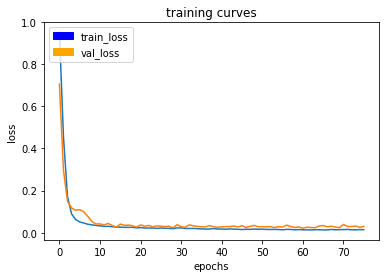

70/70 [==============================] - 55s - loss: 0.0142 - val_loss: 0.0299
Epoch 77/100
69/70 [============================>.] - ETA: 0s - loss: 0.0126

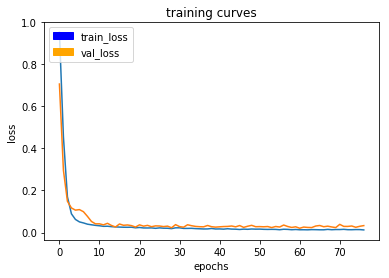

70/70 [==============================] - 55s - loss: 0.0126 - val_loss: 0.0331
Epoch 78/100
69/70 [============================>.] - ETA: 0s - loss: 0.0139

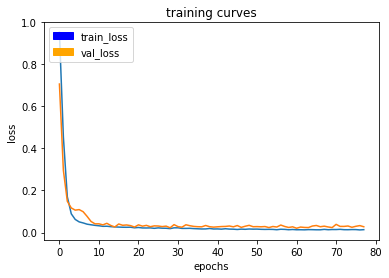

70/70 [==============================] - 54s - loss: 0.0138 - val_loss: 0.0276
Epoch 79/100
69/70 [============================>.] - ETA: 0s - loss: 0.0130

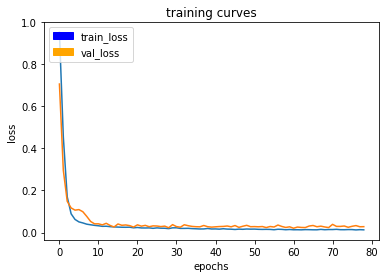

70/70 [==============================] - 55s - loss: 0.0130 - val_loss: 0.0281
Epoch 80/100
69/70 [============================>.] - ETA: 0s - loss: 0.0131

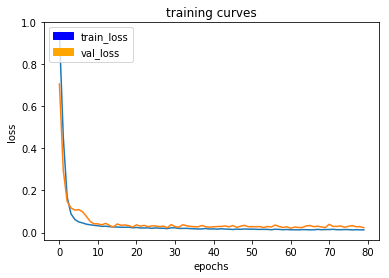

70/70 [==============================] - 55s - loss: 0.0131 - val_loss: 0.0236
Epoch 81/100
69/70 [============================>.] - ETA: 0s - loss: 0.0129

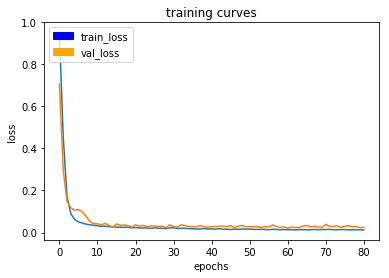

70/70 [==============================] - 55s - loss: 0.0129 - val_loss: 0.0244
Epoch 82/100
69/70 [============================>.] - ETA: 0s - loss: 0.0121

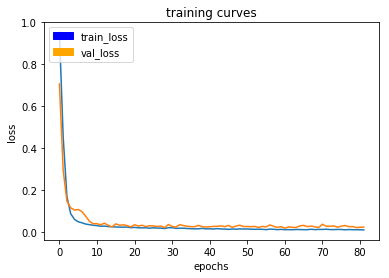

70/70 [==============================] - 55s - loss: 0.0121 - val_loss: 0.0254
Epoch 83/100
69/70 [============================>.] - ETA: 0s - loss: 0.0120

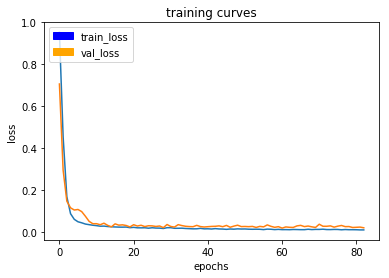

70/70 [==============================] - 55s - loss: 0.0120 - val_loss: 0.0221
Epoch 84/100
69/70 [============================>.] - ETA: 0s - loss: 0.0118

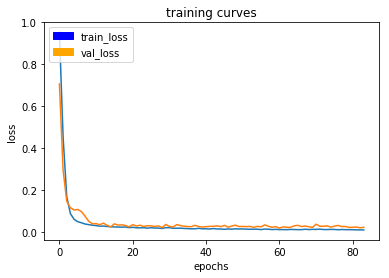

70/70 [==============================] - 55s - loss: 0.0119 - val_loss: 0.0244
Epoch 85/100
69/70 [============================>.] - ETA: 0s - loss: 0.0120

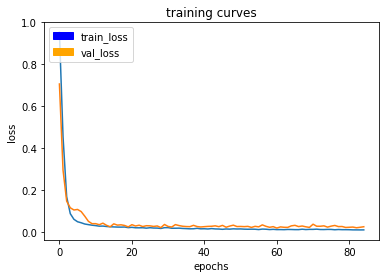

70/70 [==============================] - 55s - loss: 0.0120 - val_loss: 0.0269
Epoch 86/100
69/70 [============================>.] - ETA: 0s - loss: 0.0121

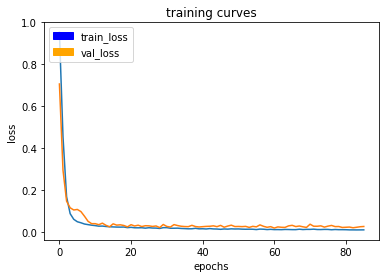

70/70 [==============================] - 55s - loss: 0.0121 - val_loss: 0.0281
Epoch 87/100
69/70 [============================>.] - ETA: 0s - loss: 0.0128

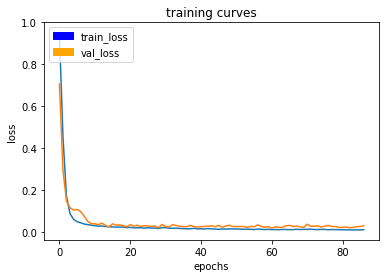

70/70 [==============================] - 55s - loss: 0.0129 - val_loss: 0.0319
Epoch 88/100
69/70 [============================>.] - ETA: 0s - loss: 0.0130

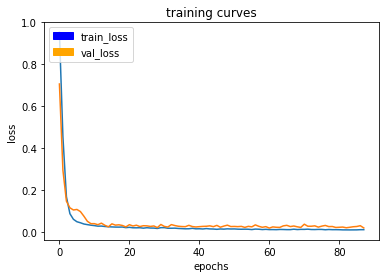

70/70 [==============================] - 55s - loss: 0.0130 - val_loss: 0.0212
Epoch 89/100
69/70 [============================>.] - ETA: 0s - loss: 0.0124

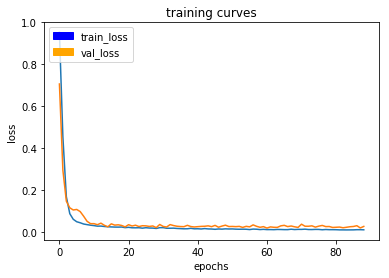

70/70 [==============================] - 55s - loss: 0.0124 - val_loss: 0.0285
Epoch 90/100
69/70 [============================>.] - ETA: 0s - loss: 0.0124

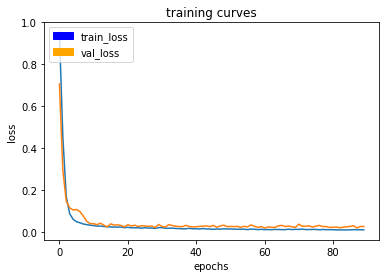

70/70 [==============================] - 55s - loss: 0.0124 - val_loss: 0.0277
Epoch 91/100
69/70 [============================>.] - ETA: 0s - loss: 0.0147

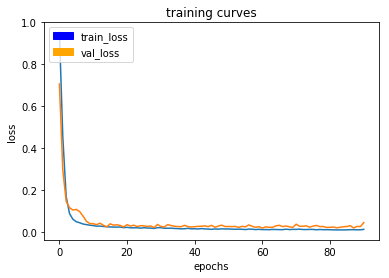

70/70 [==============================] - 55s - loss: 0.0147 - val_loss: 0.0467
Epoch 92/100
69/70 [============================>.] - ETA: 0s - loss: 0.0196

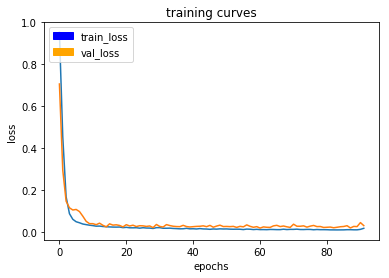

70/70 [==============================] - 55s - loss: 0.0195 - val_loss: 0.0323
Epoch 93/100
69/70 [============================>.] - ETA: 0s - loss: 0.0146

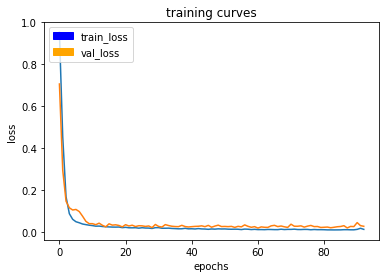

70/70 [==============================] - 56s - loss: 0.0145 - val_loss: 0.0291
Epoch 94/100
69/70 [============================>.] - ETA: 0s - loss: 0.0126

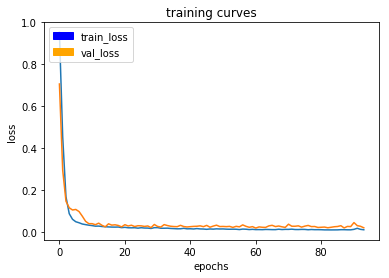

70/70 [==============================] - 55s - loss: 0.0125 - val_loss: 0.0220
Epoch 95/100
69/70 [============================>.] - ETA: 0s - loss: 0.0155

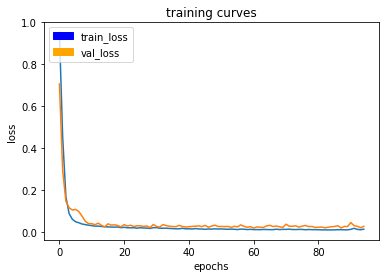

70/70 [==============================] - 55s - loss: 0.0154 - val_loss: 0.0288
Epoch 96/100
69/70 [============================>.] - ETA: 0s - loss: 0.0123

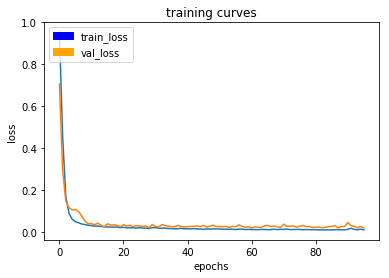

70/70 [==============================] - 55s - loss: 0.0123 - val_loss: 0.0211
Epoch 97/100
69/70 [============================>.] - ETA: 0s - loss: 0.0135

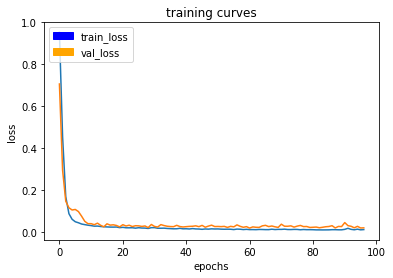

70/70 [==============================] - 55s - loss: 0.0134 - val_loss: 0.0218
Epoch 98/100
69/70 [============================>.] - ETA: 0s - loss: 0.0115

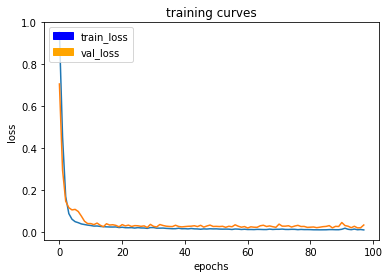

70/70 [==============================] - 55s - loss: 0.0115 - val_loss: 0.0349
Epoch 99/100
69/70 [============================>.] - ETA: 0s - loss: 0.0114

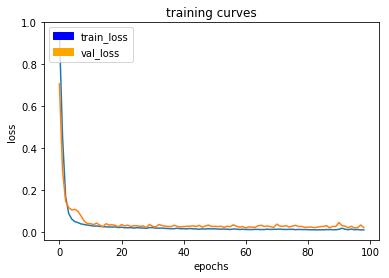

70/70 [==============================] - 55s - loss: 0.0114 - val_loss: 0.0225
Epoch 100/100
69/70 [============================>.] - ETA: 0s - loss: 0.0113

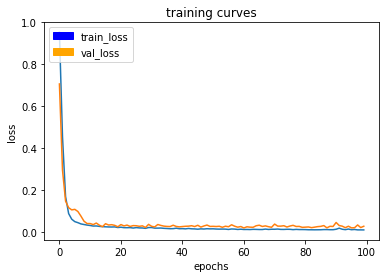

70/70 [==============================] - 55s - loss: 0.0113 - val_loss: 0.0287


In [9]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Define the Keras model and compile it for training
model = models.Model(inputs=inputs, outputs=output_layer)

model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy')

# Data iterators for loading the training and validation data
train_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                               data_folder=os.path.join('..', 'data', 'train'),
                                               image_shape=image_shape,
                                               shift_aug=True)

val_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                             data_folder=os.path.join('..', 'data', 'validation'),
                                             image_shape=image_shape)

logger_cb = plotting_tools.LoggerPlotter()
callbacks = [logger_cb]

model.fit_generator(train_iter,
                    steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                    epochs = num_epochs, # the number of epochs to train for,
                    validation_data = val_iter, # validation iterator
                    validation_steps = validation_steps, # the number of batches to validate on
                    callbacks=callbacks,
                    workers = workers)

In [10]:
# Save your trained model weights
weight_file_name = 'model_weights'
model_tools.save_network(model, weight_file_name)

## Prediction <a id='prediction'></a>

Now that you have your model trained and saved, you can make predictions on your validation dataset. These predictions can be compared to the mask images, which are the ground truth labels, to evaluate how well your model is doing under different conditions.

There are three different predictions available from the helper code provided:
- **patrol_with_targ**: Test how well the network can detect the hero from a distance.
- **patrol_non_targ**: Test how often the network makes a mistake and identifies the wrong person as the target.
- **following_images**: Test how well the network can identify the target while following them.

In [11]:
# If you need to load a model which you previously trained you can uncomment the codeline that calls the function below.

weight_file_name = 'model_weights'
restored_model = model_tools.load_network(weight_file_name)
print(restored_model)

The following cell will write predictions to files and return paths to the appropriate directories.
The `run_num` parameter is used to define or group all the data for a particular model run. You can change it for different runs. For example, 'run_1', 'run_2' etc.

In [12]:
run_num = 'run_1'

val_with_targ, pred_with_targ = model_tools.write_predictions_grade_set(model,
                                        run_num,'patrol_with_targ', 'sample_evaluation_data') 

val_no_targ, pred_no_targ = model_tools.write_predictions_grade_set(model, 
                                        run_num,'patrol_non_targ', 'sample_evaluation_data') 

val_following, pred_following = model_tools.write_predictions_grade_set(model,
                                        run_num,'following_images', 'sample_evaluation_data')

Now lets look at your predictions, and compare them to the ground truth labels and original images.
Run each of the following cells to visualize some sample images from the predictions in the validation set.

[('../data/sample_evaluation_data/following_images/images/0_run1cam1_00480.jpeg', '../data/sample_evaluation_data/following_images/masks/0__mask_00480.png', '../data/runs/following_images_run_1/0_run1cam1_00480_prediction.png'), ('../data/sample_evaluation_data/following_images/images/1_run3cam1_00043.jpeg', '../data/sample_evaluation_data/following_images/masks/1__mask_00043.png', '../data/runs/following_images_run_1/1_run3cam1_00043_prediction.png'), ('../data/sample_evaluation_data/following_images/images/0_run1cam1_00166.jpeg', '../data/sample_evaluation_data/following_images/masks/0__mask_00166.png', '../data/runs/following_images_run_1/0_run1cam1_00166_prediction.png'), ('../data/sample_evaluation_data/following_images/images/0_run1cam1_00756.jpeg', '../data/sample_evaluation_data/following_images/masks/0__mask_00756.png', '../data/runs/following_images_run_1/0_run1cam1_00756_prediction.png'), ('../data/sample_evaluation_data/following_images/images/0_run1cam1_00039.jpeg', '../da

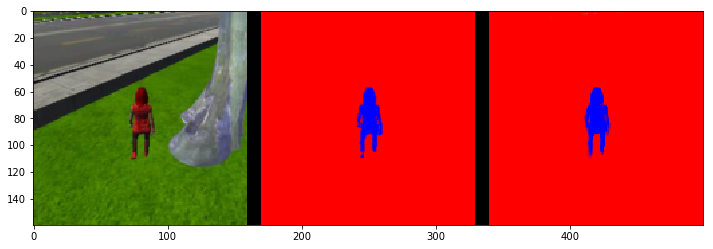

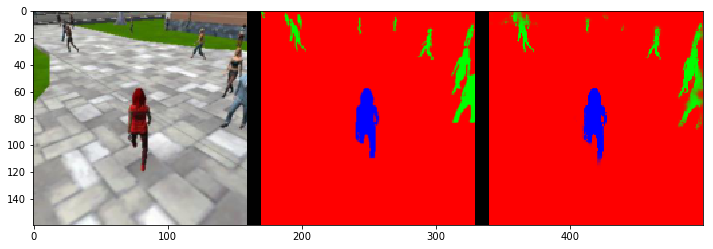

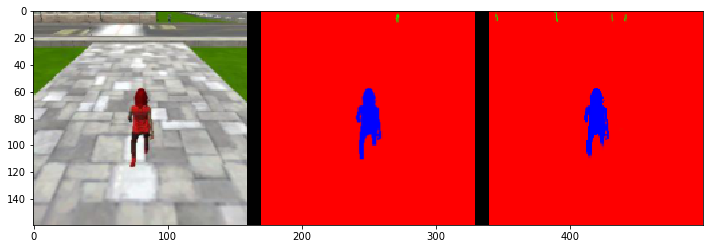

In [13]:
# images while following the target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','following_images', run_num) 
print(im_files)
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
    

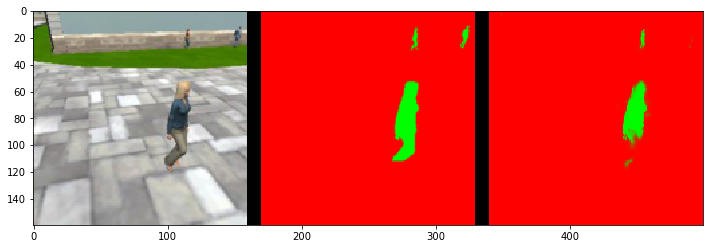

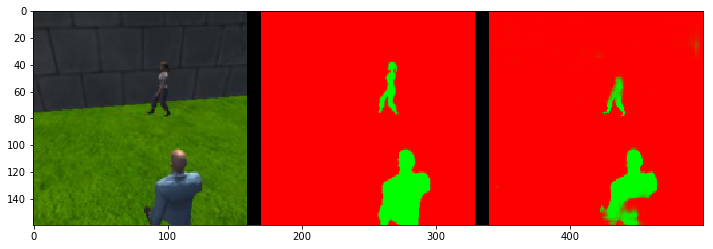

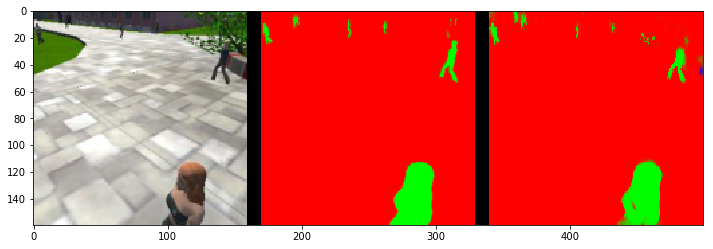

In [14]:
# images while at patrol without target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_non_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
 

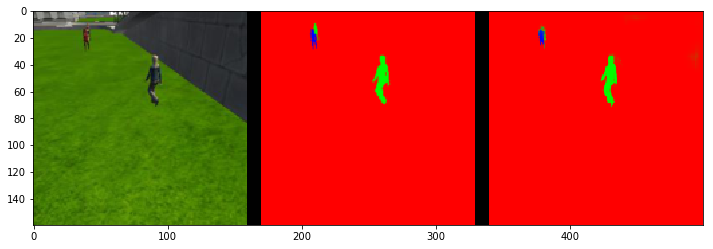

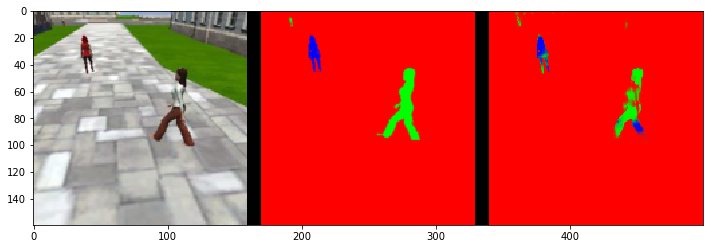

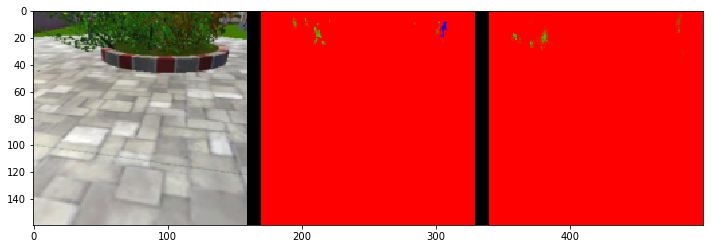

In [15]:
   
# images while at patrol with target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_with_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)

## Evaluation <a id='evaluation'></a>
Evaluate your model! The following cells include several different scores to help you evaluate your model under the different conditions discussed during the Prediction step. 

In [16]:
# Scores for while the quad is following behind the target. 
true_pos1, false_pos1, false_neg1, iou1 = scoring_utils.score_run_iou(val_following, pred_following)

number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.995813968663862
average intersection over union for other people is 0.36535462957107945
average intersection over union for the hero is 0.9065943371055372
number true positives: 539, number false positives: 0, number false negatives: 0


In [17]:
# Scores for images while the quad is on patrol and the target is not visable
true_pos2, false_pos2, false_neg2, iou2 = scoring_utils.score_run_iou(val_no_targ, pred_no_targ)

number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.9881385023036608
average intersection over union for other people is 0.7626612912710273
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 46, number false negatives: 0


In [18]:
# This score measures how well the neural network can detect the target from far away
true_pos3, false_pos3, false_neg3, iou3 = scoring_utils.score_run_iou(val_with_targ, pred_with_targ)

number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.9964748491866304
average intersection over union for other people is 0.45110848333950126
average intersection over union for the hero is 0.20625342789578852
number true positives: 122, number false positives: 3, number false negatives: 179


In [19]:
# Sum all the true positives, etc from the three datasets to get a weight for the score
true_pos = true_pos1 + true_pos2 + true_pos3
false_pos = false_pos1 + false_pos2 + false_pos3
false_neg = false_neg1 + false_neg2 + false_neg3

weight = true_pos/(true_pos+false_neg+false_pos)
print(weight)

0.7435320584926884


In [20]:
# The IoU for the dataset that never includes the hero is excluded from grading
final_IoU = (iou1 + iou3)/2
print(final_IoU)

0.556423882501


In [21]:
# And the final grade score is 
final_score = final_IoU * weight
print(final_score)

0.41371899475
